In [ ]:
# open associativity_data.csv in read
with open("associativity_data.csv", "r") as file:
    data = file.read()

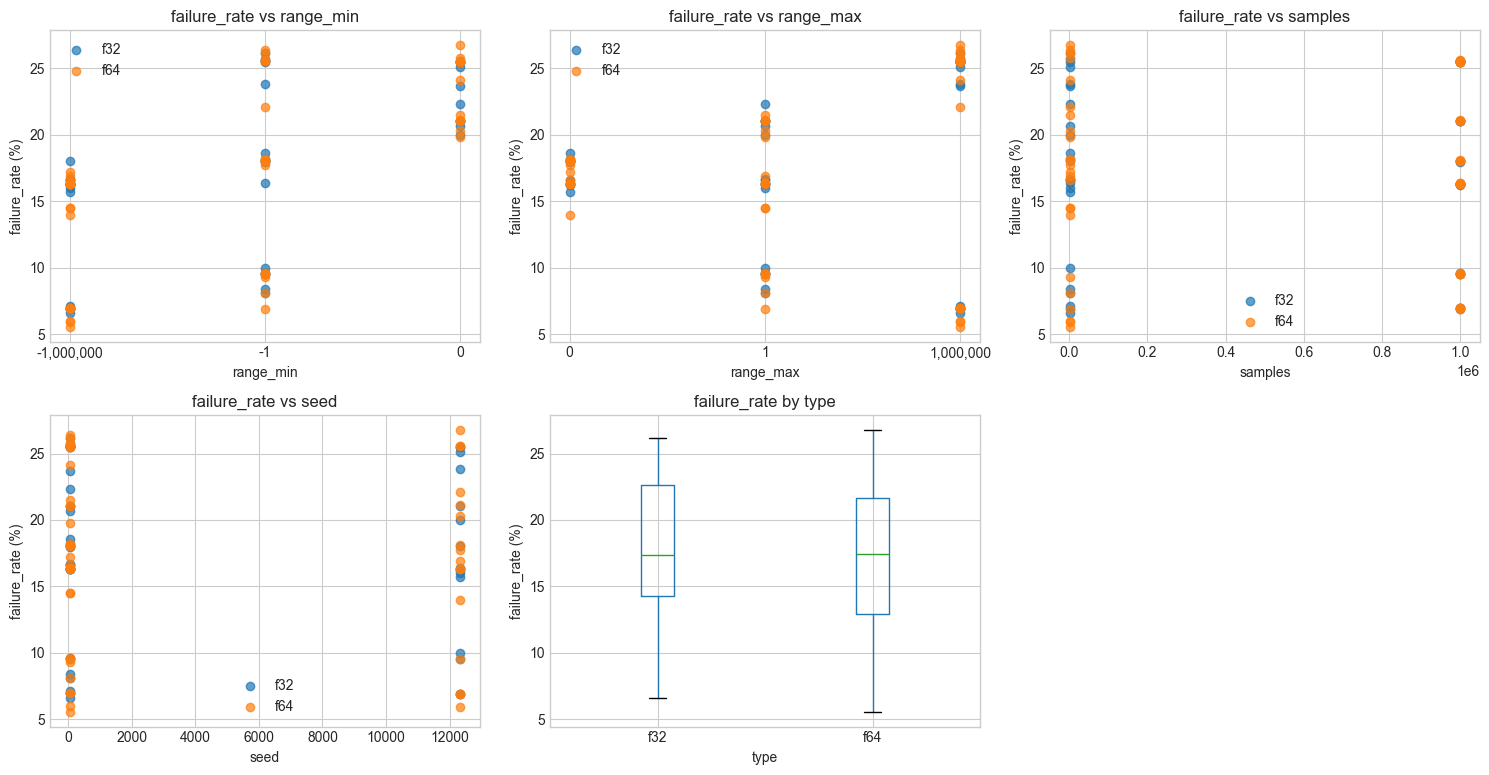

In [7]:
import io
import pandas as pd

import matplotlib.pyplot as plt

# load CSV from the existing `data` string
df = pd.read_csv(io.StringIO(data))

# clean failure_rate column (remove % and convert to float)
df['failure_rate'] = df['failure_rate'].str.rstrip('%').astype(float)

# ensure numeric types for plotting
for col in ['range_min', 'range_max', 'samples', 'seed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create plots: failure_rate vs each parameter, colored by 'type'
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

params = ['range_min', 'range_max', 'samples', 'seed']

# define categorical orders for range_min and range_max to avoid linear numeric spacing
range_orders = {
    'range_min': [-1000000, -1, 0],
    'range_max': [0, 1, 1000000],
}

for i, param in enumerate(params):
    ax = axes[i]
    if param in range_orders:
        order = range_orders[param]
        mapping = {v: idx for idx, v in enumerate(order)}
        for t, g in df.groupby('type'):
            x = g[param].map(mapping)
            ax.scatter(x, g['failure_rate'], label=t, alpha=0.7)
        ax.set_xticks(list(mapping.values()))
        ax.set_xticklabels([f"{v:,}" for v in order])
    else:
        for t, g in df.groupby('type'):
            ax.scatter(g[param], g['failure_rate'], label=t, alpha=0.7)
    ax.set_xlabel(param)
    ax.set_ylabel('failure_rate (%)')
    ax.set_title(f'failure_rate vs {param}')
    ax.legend()

# boxplot of failure_rate by type
ax = axes[4]
df.boxplot(column='failure_rate', by='type', ax=ax)
ax.set_title('failure_rate by type')
ax.set_xlabel('type')
ax.set_ylabel('failure_rate (%)')
plt.suptitle('')

# hide the unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

Decision tree rules:
|--- range_min <= -0.5000
|   |--- range_min <= -500000.5000
|   |   |--- range_max <= 500000.5000
|   |   |   |--- value: [16.2097]
|   |   |--- range_max >  500000.5000
|   |   |   |--- value: [6.6349]
|   |--- range_min >  -500000.5000
|   |   |--- range_max <= 500000.5000
|   |   |   |--- value: [13.4833]
|   |   |--- range_max >  500000.5000
|   |   |   |--- value: [25.3164]
|--- range_min >  -0.5000
|   |--- range_max <= 500000.5000
|   |   |--- seed <= 6193.5000
|   |   |   |--- value: [21.0590]
|   |   |--- seed >  6193.5000
|   |   |   |--- value: [20.6207]
|   |--- range_max >  500000.5000
|   |   |--- seed <= 6193.5000
|   |   |   |--- value: [25.1449]
|   |   |--- seed >  6193.5000
|   |   |   |--- value: [25.7431]



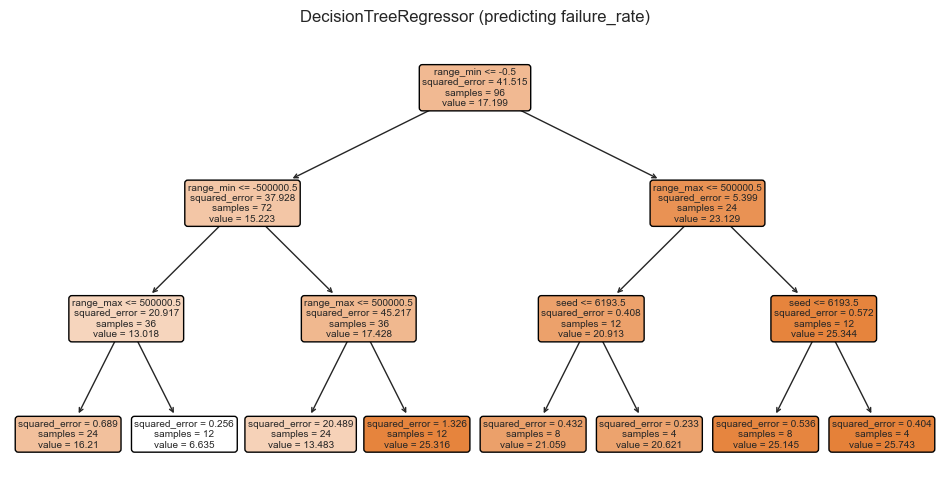

Best leaf id: 4, predicted failure_rate = 6.6349%
Rule for best leaf (conditions to minimize failure_rate):
 - range_min <= -0.5000
 - range_min <= -500000.5000
 - range_max > 500000.5000

Examples of parameter settings in this leaf (most common):
type  range_min  range_max  samples  seed 
f32   -1000000   1000000    1000     40       1
                                     42       1
                                     12345    1
                            1000000  40       1
                                     42       1
                                     12345    1
f64   -1000000   1000000    1000     40       1
                                     42       1
                                     12345    1
                            1000000  40       1
Name: count, dtype: int64

Type encoding map: {0: 'f32', 1: 'f64'}


In [8]:
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Decision tree to find parameter regions that minimize failure_rate

# prepare data (uses existing df)
feat_cols = ['type', 'range_min', 'range_max', 'samples', 'seed']
X = df[feat_cols].copy()

# encode categorical 'type'
le = LabelEncoder()
X['type_enc'] = le.fit_transform(X['type'])
X = X[['type_enc', 'range_min', 'range_max', 'samples', 'seed']]

y = df['failure_rate']

# train an interpretable tree
reg = DecisionTreeRegressor(max_depth=3, random_state=0)
reg.fit(X, y)

# print textual rules
feature_names = ['type_enc', 'range_min', 'range_max', 'samples', 'seed']
print("Decision tree rules:")
print(export_text(reg, feature_names=feature_names, decimals=4))

# plot the tree for visual inspection
plt.figure(figsize=(12,6))
plot_tree(reg, feature_names=feature_names, filled=True, rounded=True, precision=3)
plt.title("DecisionTreeRegressor (predicting failure_rate)")
plt.show()

# find leaf nodes and the one with lowest predicted failure_rate
leaf_ids = reg.apply(X)
preds = reg.predict(X)
leaf_stats = {}
for leaf, pred_val in zip(leaf_ids, preds):
    leaf_stats.setdefault(leaf, []).append(pred_val)
leaf_mean = {leaf: np.mean(vals) for leaf, vals in leaf_stats.items()}
best_leaf = min(leaf_mean, key=leaf_mean.get)
print(f"Best leaf id: {best_leaf}, predicted failure_rate = {leaf_mean[best_leaf]:.4f}%")

# helper to extract human-readable rule for a leaf
tree = reg.tree_
def find_path(node_id, target_leaf, path):
    if node_id == target_leaf and tree.children_left[node_id] == -1:
        return path
    if tree.children_left[node_id] == -1:
        return None
    # left branch
    f = feature_names[tree.feature[node_id]]
    thr = tree.threshold[node_id]
    left_path = find_path(tree.children_left[node_id], target_leaf, path + [f"{f} <= {thr:.4f}"])
    if left_path:
        return left_path
    right_path = find_path(tree.children_right[node_id], target_leaf, path + [f"{f} > {thr:.4f}"])
    return right_path

rule = find_path(0, best_leaf, [])
print("Rule for best leaf (conditions to minimize failure_rate):")
for cond in rule:
    print(" -", cond)

# show the most common parameter combinations that fall into that leaf
rows_in_best = df[leaf_ids == best_leaf]
print("\nExamples of parameter settings in this leaf (most common):")
print(rows_in_best[feat_cols].value_counts().head(10))

# decode type_enc back to original labels for clarity
print("\nType encoding map:", dict(enumerate(le.classes_)))